In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        ;


## Load data

In [2]:
%matplotlib inline
import IPython.core.display       
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from scipy import signal

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras import backend as K
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
K.set_image_data_format('channels_last')

2.6.0 2.6.0


In [4]:
img_file_names = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'train.csv' in filename:
            train_csv = os.path.join(dirname, filename)
            train_df = pd.read_csv(train_csv)
            continue
        elif 'test.csv' in filename:
            test_csv = os.path.join(dirname, filename)
            test_df = pd.read_csv(test_csv)
            continue

In [5]:
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [6]:
test_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


## visualization

In [7]:
# import matplotlib.pyplot as plt

# plt.hist(train_df['Pawpularity'], bins=100)
# plt.axvline(train_df['Pawpularity'].mean(),color='red')
# plt.axvline(train_df['Pawpularity'].median(),color='green')
# plt.ylabel('count')

In [8]:
# import seaborn as sns
# cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory','Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

# for col in cols:
#     fig, ax = plt.subplots(1, 2)
#     pos = [0,1]
#     sns.violinplot(x = train_df[col], y = train_df['Pawpularity'], ax=ax[0])
#     sns.histplot(data = train_df, hue=col, x ='Pawpularity',ax=ax[1])
    
#     plt.suptitle(col)
#     fig.show()

## Load images

In [9]:
train_path = '/kaggle/input/petfinder-pawpularity-score/train/'
test_path = '/kaggle/input/petfinder-pawpularity-score/test/'

In [10]:
%%time
##train set
import skimage.io
import skimage.transform
imgdata = []
classes = []
for i in range(len(train_df['Id'].tolist())):
    img_file_name = train_path + train_df['Id'].tolist()[i] + '.jpg'
    img_file_names.append(img_file_name)
    img = skimage.io.imread(img_file_name)
    img2 = skimage.transform.resize(img, (128,128), anti_aliasing=False)
    imgdata.append(img2)
    classes.append(train_df['Pawpularity'].tolist()[i])

CPU times: user 15min 43s, sys: 11min 15s, total: 26min 58s
Wall time: 9min 21s


In [11]:
%%time
##test set
imgdata_test = []
for i in range(len(test_df['Id'].tolist())):
    img_file_name = test_path + test_df['Id'].tolist()[i] + '.jpg'
    img = skimage.io.imread(img_file_name)
    img2 = skimage.transform.resize(img, (128,128), anti_aliasing=False)
    imgdata_test.append(img2)

CPU times: user 149 ms, sys: 91.7 ms, total: 241 ms
Wall time: 93.2 ms


In [12]:
# %%time
# plt.figure(figsize=(9,5))
# for i in range(8):
#     plt.subplot(2,4,i+1)
#     ind = i*100
#     plt.imshow(imgdata[ind])    
#     plt.title('Pawpularity: '+str(classes[ind]))
#     plt.axis('off')
# plt.show()

In [13]:
# %%time
# plt.figure(figsize=(9,5))
# for i in range(8):
#     plt.subplot(2,4,i+1)
#     ind = i
#     plt.imshow(imgdata_test[ind])    
#     plt.axis('off')
# plt.show()

## CNN

In [14]:
imgdata[0].shape

(128, 128, 3)

In [15]:
%%time
from keras.preprocessing import image
import tensorflow.keras.applications.resnet50 as resnet
Xim_list=[]
for img in imgdata:
    xi = image.img_to_array(img)
    #xi = expand_dims(xi, axis=0)
    #xi = resnet.preprocess_input(xi)
    Xim_list.append(xi)
Xim = np.array(Xim_list)
print(Xim.shape)

(9912, 128, 128, 3)
CPU times: user 1.32 s, sys: 1.76 s, total: 3.08 s
Wall time: 3.09 s


In [16]:
from sklearn.model_selection import train_test_split
classes = np.array(classes)
x_train, x_test, y_train, y_test = train_test_split(Xim, classes, test_size=0.1, random_state=7)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8920, 128, 128, 3)
(992, 128, 128, 3)
(8920,)
(992,)


In [17]:
from tensorflow.keras.regularizers import l2
def get_model():
    tf.keras.backend.clear_session()
    np.random.seed(4487)
    tf.random.set_seed(4487)
    
    input_ = keras.Input(shape=(128,128,3))
    x = keras.layers.Conv2D(filters = 16, kernel_size=[7,7], strides=[2,2], padding='valid', kernel_initializer='he_normal',
                           kernel_regularizer=l2(0.0005), activation = 'relu')(input_)
    x = keras.layers.Conv2D(filters = 32, kernel_size=[3,3], padding='same', kernel_initializer='he_normal',
                           activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters = 32, kernel_size=[3,3],strides=[2,2], padding='same', kernel_initializer='he_normal',
                           activation = 'relu', kernel_regularizer=l2(0.0005))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(filters = 64, kernel_size=[3,3], padding='same', kernel_initializer='he_normal', activation='relu'
                            ,kernel_regularizer=l2(0.0002))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding='same',
                               kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = "relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs = input_, outputs = output)    
    return model

In [18]:
model = get_model()
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 16)        2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0     

In [19]:
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [21]:
kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=1024),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 1024,
    epochs = 40, callbacks=[kall]
)

2021-12-01 02:58:58.265401: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
8/8 [==============================] - 83s 10s/step - loss: 805.5736 - rmse: 28.3784 - val_loss: 1710.3903 - val_rmse: 41.3540
Epoch 2/40
8/8 [==============================] - 80s 10s/step - loss: 477.8760 - rmse: 21.8549 - val_loss: 1442.3440 - val_rmse: 37.9750
Epoch 3/40
8/8 [==============================] - 80s 10s/step - loss: 455.3086 - rmse: 21.3323 - val_loss: 1247.5393 - val_rmse: 35.3171
Epoch 4/40
8/8 [==============================] - 79s 10s/step - loss: 446.7804 - rmse: 21.1315 - val_loss: 1230.0128 - val_rmse: 35.0681
Epoch 5/40
8/8 [==============================] - 80s 10s/step - loss: 446.5940 - rmse: 21.1270 - val_loss: 1101.4235 - val_rmse: 33.1841
Epoch 6/40
8/8 [==============================] - 80s 10s/step - loss: 440.6144 - rmse: 20.9850 - val_loss: 1009.4823 - val_rmse: 31.7685
Epoch 7/40
8/8 [==============================] - 79s 10s/step - loss: 446.4308 - rmse: 21.1232 - val_loss: 863.9815 - val_rmse: 29.3894
Epoch 8/40
8/8 [===================

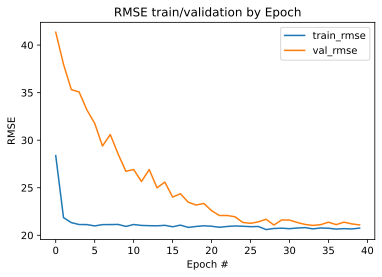

In [22]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

## Submission

In [23]:
##extract tensor
Xim_list_test=[]
for img in imgdata_test:
    xi = image.img_to_array(img)
    Xim_list_test.append(xi)
Xim_test = np.array(Xim_list_test)
print(Xim_test.shape)

(8, 128, 128, 3)


In [24]:
cnn_pred = model.predict(Xim_test)
Id = test_df['Id'].tolist()
print(cnn_pred.shape)

(8, 1)


In [25]:
res = cnn_pred.ravel().tolist()
print(res)

[26.159408569335938, 29.225601196289062, 29.46492576599121, 27.013635635375977, 25.687673568725586, 28.07286834716797, 27.03956413269043, 26.564022064208984]


In [26]:
submission = pd.DataFrame({'Id':Id, 'Pawpularity':res})
submission.to_csv('submission.csv',index=None)
print('done')

done
